# Modeling

## Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (ConfusionMatrixDisplay,
    classification_report, RocCurveDisplay)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (cross_val_score, GridSearchCV, 
                                     train_test_split)
from sklearn.pipeline import Pipeline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import elu
from tensorflow.keras.optimizers.experimental import Adagrad
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.random import set_seed

2023-01-20 15:45:52.434880: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Read Cleaned Data

From the data cleaning notebook, there are two different files:
1. `annual_aqi_clean.csv` is annual summary data from the EPA's AirData system
2. `aqs_by_county_clean.csv` is sensor data that was collected via the EPA's AQS API

The annual summary data will contain more information on the number of days in various areas such as days with AQI measureed, good, moderate, unhealthy, very unhealthy, and hazardous air quality.  There are also columns concerning specific pollutant measurements like pm2.5, pm10, and ozone.

The AQS data is also annual summary data, but on a measured pollutant basis.  So it contains values for measurements of specific pollutants in counties for the year.

In [4]:
# Annual AQI summary data
aqi = pd.read_csv('../data/annual_aqi_clean.csv')

# AQS sensor data collected via API
aqs = pd.read_csv('../data/aqs_by_county_clean.csv')

In [3]:
aqi.columns

Index(['state', 'county', 'year', 'days_with_aqi', 'good_days', 'mod_days',
       'uh_sens_days', 'uh_days', 'v_uh_days', 'haz_days', 'max_aqi',
       '90_per_aqi', 'median_aqi', 'days_co', 'days_no2', 'days_ozone',
       'days_pm2.5', 'days_pm10', 'births_low', 'avg_weight_low',
       'avg_ges_age_low', 'births_all', 'avg_weight_all', 'avg_ges_age_all',
       'pct_low', 'high_rate'],
      dtype='object')

### Filter Data

The EPA generally uses 75% as a number of observations to ensure relevancy.  So we'll filter the aqi data to only look at records where `days_with_aqi` is greater than 75% of the days in a year.

In [4]:
aqi = aqi[aqi['days_with_aqi'] > (365 * .75)]

## Annual AQI Modeling

In this section, various models will be checked to see if it is viable to create a model based on the annual AQI data for classification of a "high_rate" of low birth weights for a county based on the previous year's AQI data.


All of the various day counts, with the exception of the `days_with_aqi` will be included.  Days with AQI only indicates how many days air quality was measured and doesn't indicate any function of air quality.

### AQI Neural Net Classification

A densely connected neural net will be built for classification to see if this seems like it might be able to outperform baseline.

#### Define X, y, train/test split

In [5]:
# define features (X) and target (y)
X_aqi = aqi[['good_days', 'mod_days','uh_sens_days', 'uh_days', 
         'v_uh_days', 'haz_days', 'max_aqi', '90_per_aqi', 
         'median_aqi', 'days_co', 'days_no2', 'days_ozone',
         'days_pm2.5', 'days_pm10']]

y_aqi = aqi['high_rate']

Train test split the AQI data

In [6]:
X_aqi_train, X_aqi_test, y_aqi_train, y_aqi_test = \
train_test_split(X_aqi, y_aqi, 
                 test_size=.2,
                 stratify=y_aqi,
                 random_state=5)

X_aqi_train.shape, X_aqi_test.shape, y_aqi_train.shape, y_aqi_test.shape

((3242, 14), (811, 14), (3242,), (811,))

#### Check Class Balance / Baseline
Check the class balance across the data set for baseline:

In [7]:
y_aqi.value_counts(normalize=True)

0    0.659018
1    0.340982
Name: high_rate, dtype: float64

Check the class balance of both the train and test splits to ensure the stratification worked.

In [8]:
print(f'Train split:\n{y_aqi_train.value_counts(normalize=True)}\n')
print(f'Test split:\n{y_aqi_test.value_counts(normalize=True)}')

Train split:
0    0.659161
1    0.340839
Name: high_rate, dtype: float64

Test split:
0    0.658446
1    0.341554
Name: high_rate, dtype: float64


**Baseline = 0.658**

#### Scale Data
Standardize the data to prepare for Neural Net model.

In [9]:
# instantiate standardscaler
ss = StandardScaler()

# fit_transform X train
X_aqi_train_ss = ss.fit_transform(X_aqi_train)

# transform test
X_aqi_test_ss = ss.transform(X_aqi_test)

#### Build Model(s)

In [10]:
# # aqi_model_01
# set_seed(42)

# # Winston had found this activation performed better than ReLu
# # so trying it here
# custom_elu = lambda x: elu(x, alpha=1e-3)

# best_model_saver = ModelCheckpoint(filepath='data/models/aqi_model',
#                                    monitor='val_accuracy',
#                                    save_best_only=True,
#                                    initial_value_threshold=.90,
#                                    save_weights_only=True,
#                                    mode='max')


# # build the neural network topology
# model = Sequential()

# # add hidden layers
# model.add(Dense(16, 
#                 input_dim=X_aqi_train_ss.shape[1], 
#                 activation=custom_elu,
#                 kernel_regularizer=l2(0.001)
#                )
#          )
# model.add(Dropout(0.2))
# model.add(Dense(60, activation=custom_elu))
# model.add(Dropout(0.2))
# model.add(Dense(120, activation=custom_elu))
# model.add(Dropout(0.2))
# model.add(Dense(60, activation=custom_elu))

# # output layer with sigmoid activation for binary classification
# model.add(Dense(1, activation='sigmoid'))

# # compile model using adam optimizer and binary crossentropy for loss
# model.compile(optimizer='adam', 
#               loss='bce', 
#               metrics=['accuracy'])

# aqi_model_02 relplace elu with relu
set_seed(42)

# Winston had found this activation performed better than ReLu
# so trying it here
# custom_elu = lambda x: elu(x, alpha=1e-3)

best_model_saver = ModelCheckpoint(filepath='data/models/aqi_model',
                                   monitor='val_accuracy',
                                   save_best_only=True,
                                   initial_value_threshold=.90,
                                   save_weights_only=True,
                                   mode='max')


# build the neural network topology
model = Sequential()

# add hidden layers
model.add(Dense(16, 
                input_dim=X_aqi_train_ss.shape[1], 
                activation='relu',
                kernel_regularizer=l2(0.001)
               )
         )
model.add(Dropout(0.2))
model.add(Dense(60, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(120, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(60, activation='relu'))

# output layer with sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

# compile model using adam optimizer and binary crossentropy for loss
model.compile(optimizer='adam', 
              loss='bce', 
              metrics=['accuracy'])

In [11]:
# fit the model and save return as history
aqi_nn_history = model.fit(X_aqi_train_ss, 
                           y_aqi_train,
                           batch_size=16, 
                           epochs=100,
                           callbacks=[best_model_saver],
                           validation_data=(X_aqi_test_ss, y_aqi_test),
                           verbose=0 # to cut down on notebook length
                          )

2023-01-20 09:37:37.641365: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


#### Plot Accuracy and Loss

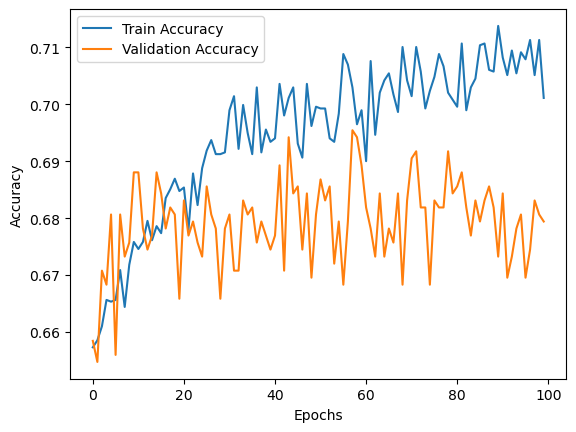

In [12]:
plt.plot(aqi_nn_history.history['accuracy'], label='Train Accuracy')
plt.plot(aqi_nn_history.history['val_accuracy'], label='Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend();

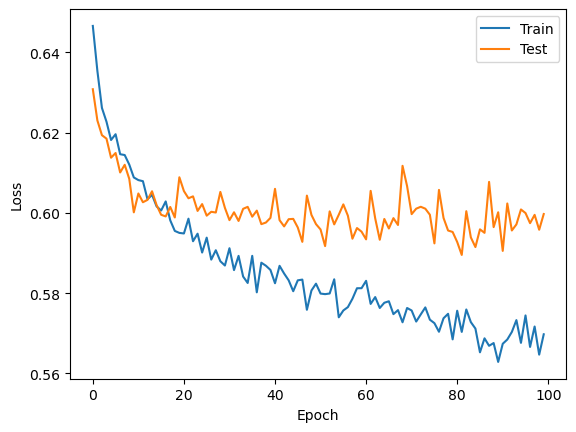

In [13]:
plt.plot(aqi_nn_history.history['loss'], label='Train')
plt.plot(aqi_nn_history.history['val_loss'], label='Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

### AQI Random Forest Classification

#### AQI Data

In [14]:
rand_forest = RandomForestClassifier()

In [15]:
rand_forest.fit(X_aqi_train, y_aqi_train)

RandomForestClassifier()

In [16]:
cross_val_score(rand_forest, X_aqi_train, y_aqi_train).mean()

0.689079590633263

In [17]:
# score with defaults
rand_forest.score(X_aqi_train, y_aqi_train), rand_forest.score(X_aqi_test, y_aqi_test)

(1.0, 0.6954377311960542)

In [18]:
# configure pipeline
rf_pipe = Pipeline([
    ('rf', RandomForestClassifier())
])

# min_samples_leaf
# criterion

rf_params = {
    'rf__n_estimators': [100, 125, 150],
    'rf__max_depth': [5, 15, 25],
    'rf__min_samples_leaf': [3, 5, 6, 7],
    'rf__bootstrap': [False],
    'rf__warm_start': [True, False],
    'rf__max_features': ['sqrt', 3, 6, 8, 9]
}


# attempt 6 
# rf_params = {
#     'rf__n_estimators': [100, 125, 150],
#     'rf__max_depth': [5, 15, 25],
#     'rf__min_samples_leaf': [3, 5, 6, 7],
#     'rf__bootstrap': [False],
#     'rf__warm_start': [True, False],
#     'rf__max_features': ['sqrt', 3, 6, 8, 9]
# }

# attempt 5 - first parameters with leaf instead of split
# rf_params = {
#     'rf__n_estimators': [10, 50, 100],
#     'rf__max_depth': [5, 10, 15],
#     'rf__min_samples_leaf': [2, 3, 4, 5],
#     'rf__bootstrap': [True, False],
#     'rf__warm_start': [True, False],
#     'rf__max_features': ['sqrt', 3, 4, 5, 6]
# }

# attempt 4
# rf_params = {
#     'rf__n_estimators': [100, 125, 150, 200],
#     'rf__max_depth': [10, 15, 20, 25, 100],
#     'rf__min_samples_leaf': [4, 5, 6, 7],
#     'rf__bootstrap': [False],
#     'rf__warm_start': [True, False],
#     'rf__max_features': ['sqrt', 4, 5, 6, 7]
# }

# attempt 3
# rf_params = {
#     'rf__n_estimators': [100, 125, 150, 200],
#     'rf__max_depth': [10, 15, 20, 25],
#     'rf__min_samples_split': [4, 5, 6, 7],
#     'rf__bootstrap': [False],
#     'rf__warm_start': [True, False],
#     'rf__max_features': ['sqrt', 4, 5, 6, 7]
# }

# attempt 2
# rf_params = {
#     'rf__n_estimators': [50, 100, 150],
#     'rf__max_depth': [10, 20, 50],
#     'rf__min_samples_split': [5, 10, 25],
#     'rf__bootstrap': [True, False],
#     'rf__warm_start': [True, False],
#     'rf__max_features': ['sqrt', 5, 10, 25]
# }

# attempt 1
# rf_params = {
#     'rf__n_estimators': [10, 50, 100],
#     'rf__max_depth': [5, 10, 15],
#     'rf__min_samples_split': [2, 3, 4, 5],
#     'rf__bootstrap': [True, False],
#     'rf__warm_start': [True, False],
#     'rf__max_features': ['sqrt', 3, 4, 5, 6]
# }

In [19]:
# grid search commented out so notebook can run
# gs = GridSearchCV(rf_pipe, rf_params, n_jobs=-1, verbose=1)
# gs.fit(X_train, y_train)
# gs.best_params_

# BEST PARAMS
# {'rf__bootstrap': False,
#  'rf__max_depth': 10,
#  'rf__max_features': 6,
#  'rf__min_samples_split': 5,
#  'rf__n_estimators': 100,
#  'rf__warm_start': False}

# attempt 6 (0.9580505860579889, 0.8988902589395807)
# {'rf__bootstrap': False,
#  'rf__max_depth': 15,
#  'rf__max_features': 'sqrt',
#  'rf__min_samples_leaf': 3,
#  'rf__n_estimators': 125,
#  'rf__warm_start': False}

# attempt 5 (0.9558914250462678, 0.9001233045622689)
# {'rf__bootstrap': False,
#  'rf__max_depth': 15,
#  'rf__max_features': 'sqrt',
#  'rf__min_samples_leaf': 3,
#  'rf__n_estimators': 100,
#  'rf__warm_start': False}

# attempt 4 (0.9487970388648982, 0.8976572133168927)
# {'rf__bootstrap': False,
#  'rf__max_depth': 15,
#  'rf__max_features': 6,
#  'rf__min_samples_leaf': 5,
#  'rf__n_estimators': 100,
#  'rf__warm_start': False}

# attempt 3 (0.9932140653917335, 0.9001233045622689)
# {'rf__bootstrap': False,
#  'rf__max_depth': 15,
#  'rf__max_features': 4,
#  'rf__min_samples_split': 5,
#  'rf__n_estimators': 100,
#  'rf__warm_start': False}

# attempt 2 (1.0, 0.8976572133168927)
# {'rf__bootstrap': False,
#  'rf__max_depth': 20,
#  'rf__max_features': 'sqrt',
#  'rf__min_samples_split': 5,
#  'rf__n_estimators': 150,
#  'rf__warm_start': True}

# attempt 1 (0.9401603948180136, 0.903822441430333) -- BEST PARAMS
# {'rf__bootstrap': False,
#  'rf__max_depth': 10,
#  'rf__max_features': 6,
#  'rf__min_samples_split': 5,
#  'rf__n_estimators': 100,
#  'rf__warm_start': False}

Running this cell requires running the previous cell gridsearch

In [20]:
# score with best params
# gs.score(X_aqi_train, y_aqi_train), gs.score(X_aqi_test, y_aqi_test)

### AQI Logistic Regression Classifer

#### Annual AQI Data

In [21]:
lr = LogisticRegression(max_iter=10_000)

In [22]:
y_aqi_train.value_counts(normalize=True), y_aqi_test.value_counts(normalize=True)

(0    0.659161
 1    0.340839
 Name: high_rate, dtype: float64,
 0    0.658446
 1    0.341554
 Name: high_rate, dtype: float64)

In [23]:
lr.fit(X_aqi_train, y_aqi_train)

LogisticRegression(max_iter=10000)

In [24]:
lr.score(X_aqi_train, y_aqi_train), lr.score(X_aqi_test, y_aqi_test)

(0.6674892041949414, 0.6584463625154131)

## AQS Modeling

In [5]:
X_aqs = aqs[['Carbon monoxide', 'Nitrogen dioxide (NO2)',
       'Ozone', 'PM10 Total 0-10um STP', 'PM2.5 - Local Conditions']]

y_aqs = aqs['high_rate']

In [6]:
X_train_aqs, X_test_aqs, y_train_aqs, y_test_aqs = train_test_split(X_aqs,\
                                                                   y_aqs,
                                                                   random_state=5,
                                                                    test_size=.2,                                                                
                                                                   stratify=y_aqs)

In [7]:
X_train_aqs.shape, X_test_aqs.shape, y_train_aqs.shape, y_test_aqs.shape

((809, 5), (203, 5), (809,), (203,))

In [8]:
y_train_aqs.value_counts(normalize=True), y_test_aqs.value_counts(normalize=True)

(0    0.588381
 1    0.411619
 Name: high_rate, dtype: float64,
 0    0.586207
 1    0.413793
 Name: high_rate, dtype: float64)

**Baseline: .586**

#### AQS Random Forest Classification

In [9]:
aqs_rf = RandomForestClassifier()

In [10]:
aqs_rf.fit(X_train_aqs, y_train_aqs)

RandomForestClassifier()

In [11]:
cross_val_score(aqs_rf, X_train_aqs, y_train_aqs).mean()

0.6996626025611532

In [12]:
# score with defaults
aqs_rf.score(X_train_aqs, y_train_aqs), aqs_rf.score(X_test_aqs, y_test_aqs)

(1.0, 0.7241379310344828)

In [15]:
# configure pipeline
aqs_rf_pipe = Pipeline([
    ('rf', RandomForestClassifier())
])

# min_samples_leaf
# criterion

aqs_rf_params =  {'rf__bootstrap':[False],
 'rf__criterion': ['gini'],
 'rf__max_depth': [55],
 'rf__max_features': [2],
 'rf__min_samples_leaf': [8],
 'rf__n_estimators': [25],
 'rf__warm_start': [False]}


# Attempt 4
# {
#     'rf__n_estimators': np.arange(25, 300, 50),
#     'rf__criterion' : ["gini", "entropy", "log_loss"],
#     'rf__max_depth': np.arange(5, 100, 10),
#     'rf__min_samples_leaf': np.arange(3, 11),
#     'rf__bootstrap': [False, True],
#     'rf__warm_start': [True, False],
#     'rf__max_features': np.arange(1, 6)
# }


# attempt 3
# aqs_rf_params = {
#     'rf__n_estimators': [25, 100, 150, 200],
#     'rf__max_depth': [3, 5, 25, 50],
#     'rf__min_samples_leaf': [3, 5, 6, 7, 20],
#     'rf__bootstrap': [False, True],
#     'rf__warm_start': [True, False],
#     'rf__max_features': ['sqrt', None, 3, 6, 8, 15]
# }

# attempt 2
# aqs_rf_params = {
#     'rf__n_estimators': [100, 125, 150],
#     'rf__max_depth': [5, 15, 25],
#     'rf__min_samples_leaf': [3, 5, 6, 7],
#     'rf__bootstrap': [False, True],
#     'rf__warm_start': [True, False],
#     'rf__max_features': ['sqrt', 3, 6, 8, 9]
# }


# attempt 1
# aqs_rf_params = {
#     'rf__n_estimators': [10, 50, 100],
#     'rf__max_depth': [5, 10, 15],
#     'rf__min_samples_split': [2, 3, 4, 5],
#     'rf__bootstrap': [True, False],
#     'rf__warm_start': [True, False],
#     'rf__max_features': ['sqrt', 3, 4, 5, 6]
# }

In [16]:
# commenting out so notebook can be run
aqs_gs = GridSearchCV(aqs_rf_pipe, aqs_rf_params, n_jobs=-1, verbose=1)
aqs_gs.fit(X_train_aqs, y_train_aqs)
aqs_gs.best_params_

# BEST PARAMS
# {'rf__bootstrap': False,
#  'rf__criterion': 'gini',
#  'rf__max_depth': 55,
#  'rf__max_features': 2,
#  'rf__min_samples_leaf': 8,
#  'rf__n_estimators': 25,
#  'rf__warm_start': False}


# attempt 4 (0.9245982694684796, 0.8768472906403941)
# {'rf__bootstrap': False,
#  'rf__criterion': 'gini',
#  'rf__max_depth': 55,
#  'rf__max_features': 2,
#  'rf__min_samples_leaf': 8,
#  'rf__n_estimators': 25,
#  'rf__warm_start': False}


# attempt 3 (0.9542645241038319, 0.8719211822660099)
# {'rf__bootstrap': True,
#  'rf__max_depth': 50,
#  'rf__max_features': None,
#  'rf__min_samples_leaf': 3,
#  'rf__n_estimators': 25,
#  'rf__warm_start': False}


# attempt 2 (0.8800988875154512, 0.8768472906403941)
# {'rf__bootstrap': False,
#  'rf__max_depth': 5,
#  'rf__max_features': 3,
#  'rf__min_samples_leaf': 3,
#  'rf__n_estimators': 125,
#  'rf__warm_start': False}

# attempt 1 (0.8825710754017305, 0.8768472906403941)
# {'rf__bootstrap': True,
#  'rf__max_depth': 5,
#  'rf__max_features': 'sqrt',
#  'rf__min_samples_split': 4,
#  'rf__n_estimators': 10,
#  'rf__warm_start': True}

Fitting 5 folds for each of 1 candidates, totalling 5 fits


{'rf__bootstrap': False,
 'rf__criterion': 'gini',
 'rf__max_depth': 55,
 'rf__max_features': 2,
 'rf__min_samples_leaf': 8,
 'rf__n_estimators': 25,
 'rf__warm_start': False}

Running this cell requires running the previous cell gridsearch

In [17]:
# score with best_params
aqs_gs.score(X_train_aqs, y_train_aqs), aqs_gs.score(X_test_aqs, y_test_aqs)

(0.9122373300370828, 0.645320197044335)

#### AQS Logistic Regression Classification

In [36]:
aqs.columns

Index(['state', 'county', 'year', 'Carbon monoxide', 'Nitrogen dioxide (NO2)',
       'Ozone', 'PM10 Total 0-10um STP', 'PM2.5 - Local Conditions',
       'births_low', 'avg_weight_low', 'avg_ges_age_low', 'births_all',
       'avg_weight_all', 'avg_ges_age_all', 'pct_low', 'high_rate'],
      dtype='object')

In [37]:
lr.fit(X_train_aqs, y_train_aqs)

LogisticRegression(max_iter=10000)

In [38]:
lr.score(X_train_aqs, y_train_aqs), lr.score(X_test_aqs, y_test_aqs)

(0.6106304079110012, 0.5763546798029556)

### AQS NN Classifier

#### Scale the data

In [10]:
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train_aqs)
X_test_ss = ss.transform(X_test_aqs)

#### Build the model

In [40]:
# saved as model_9261(!!!)
# set_seed(42)

# custom_elu = lambda x: elu(x, alpha=1e-2)

# best_model_saver = ModelCheckpoint(filepath='data/new_model',
#                                    monitor='val_accuracy',
#                                    save_best_only=True,
#                                    initial_value_threshold=.910,
#                                    save_weights_only=True,
#                                    mode='max',
#                                    verbose=1)

# model = Sequential()
# model.add(Dense(600, input_dim=X_train_ss.shape[1], activation=custom_elu))
# model.add(Dropout(.2))
# model.add(Dense(300, activation=custom_elu))
# model.add(Dropout(.2))
# model.add(Dense(200, activation=custom_elu))
# model.add(Dropout(.2))
# model.add(Dense(100, activation=custom_elu))
# model.add(Dropout(.2))
# model.add(Dense(50, activation=custom_elu))
# model.add(Dropout(.2))
# model.add(Dense(100, activation=custom_elu))
# model.add(Dense(1, activation='sigmoid'))

# model.compile(optimizer=Adagrad(learning_rate=.25), 
#               loss='bce', 
#               metrics=['accuracy'])

# history = model.fit(X_train_ss, y_train,
#                     batch_size=8, epochs=500,
#                     callbacks=[best_model_saver],
#                     validation_data=(X_test_ss, y_test))

#----------------------------------------------------------------------------

# saved as models_9163
# set_seed(42)

# custom_elu = lambda x: elu(x, alpha=1e-2)

# best_model_saver = ModelCheckpoint(filepath='data/models/new_model',
#                                    monitor='val_accuracy',
#                                    save_best_only=True,
#                                    initial_value_threshold=.9,
#                                    save_weights_only=True,
#                                    mode='max')

# model = Sequential()
# model.add(Dense(600, input_dim=X_train_ss.shape[1], activation=custom_elu))
# model.add(Dense(300, activation=custom_elu))
# model.add(Dense(200, activation=custom_elu))
# model.add(Dense(100, activation=custom_elu))
# model.add(Dense(50, activation=custom_elu))
# model.add(Dense(100, activation=custom_elu))
# model.add(Dense(1, activation='sigmoid'))

# model.compile(optimizer=Adagrad(learning_rate=.5), 
#               loss='bce', 
#               metrics=['accuracy'])

# history = model.fit(X_train_ss, y_train,
#                     batch_size=8, epochs=500,
#                     callbacks=[best_model_saver],
#                     validation_data=(X_test_ss, y_test))

#----------------------------------------------------------------------------

# This attempt got accuracy of .9015
# custom_elu = lambda x: elu(x, alpha=1e-2)

# model = Sequential()
# model.add(Dense(600, input_dim=X_train_ss.shape[1], activation=custom_elu))
# model.add(Dense(300, activation=custom_elu))
# model.add(Dense(200, activation=custom_elu))
# model.add(Dense(100, activation=custom_elu))
# model.add(Dense(50, activation=custom_elu))
# model.add(Dense(100, activation=custom_elu))
# model.add(Dense(1, activation='sigmoid'))

# model.compile(optimizer=Adagrad(learning_rate=.5), 
#               loss='bce', 
#               metrics=['accuracy'])

# history = model.fit(X_train_ss, y_train,
#                     batch_size=8, epochs=100,
#                     # callbacks=EarlyStopping(patience=5),
#                     validation_data=(X_test_ss, y_test))

#----------------------------------------------------------------------------

# Tried replacing elu with relu just to see difference, slightly worse performance (.8818 accuracy)
# custom_elu = lambda x: elu(x, alpha=1e-2)

# model = Sequential()
# model.add(Dense(600, input_dim=X_train_ss.shape[1], activation='relu'))
# model.add(Dense(300, activation='relu'))
# model.add(Dense(200, activation='relu'))
# model.add(Dense(100, activation='relu'))
# model.add(Dense(50, activation='relu'))
# model.add(Dense(100, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))

# model.compile(optimizer=Adagrad(learning_rate=.5), 
#               loss='bce', 
#               metrics=['accuracy'])

# history = model.fit(X_train_ss, y_train,
#                     batch_size=8, epochs=100,
#                     # callbacks=EarlyStopping(patience=5),
#                     validation_data=(X_test_ss, y_test))

#### Must run this cell in order to be able to load model results

In [11]:
set_seed(42)

custom_elu = lambda x: elu(x, alpha=1e-2)

best_model_saver = ModelCheckpoint(filepath='../data/models/new_model',
                                   monitor='val_accuracy',
                                   save_best_only=True,
                                   # initial_value_threshold=.920,
                                   save_weights_only=True,
                                   mode='max')

model = Sequential()
model.add(Dense(600, input_dim=X_train_ss.shape[1], activation=custom_elu))
model.add(Dropout(.2))
model.add(Dense(300, activation=custom_elu))
model.add(Dropout(.2))
model.add(Dense(200, activation=custom_elu))
model.add(Dropout(.2))
model.add(Dense(100, activation=custom_elu))
model.add(Dropout(.2))
model.add(Dense(50, activation=custom_elu))
model.add(Dropout(.2))
model.add(Dense(100, activation=custom_elu))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adagrad(learning_rate=.25), 
              loss='bce', 
              metrics=['accuracy'])

#### Skip this cell unless you wish to train new model

In [42]:
history = model.fit(X_train_ss, y_train_aqs,
                    batch_size=8, epochs=200,
                    callbacks=[best_model_saver],
                    validation_data=(X_test_ss, y_test_aqs),
                    verbose=0)

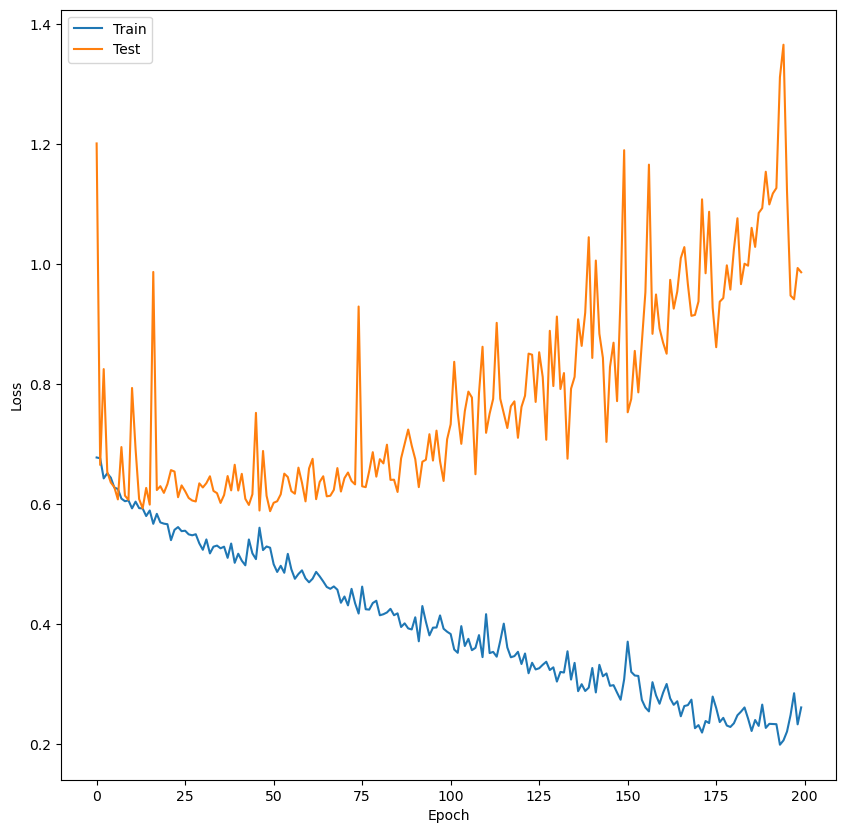

In [43]:
plt.figure(figsize=(10,10))
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.ylim([0,2])
plt.legend();

## Loading in best model

In [44]:
# This is best model from most recent training of the neural net
model.load_weights('../data/models/new_model')

In [12]:
# This is the best model as determined by accuracy/false negative rate
model.load_weights('../data/models/aqs_model_7537')

#### Generate predictions for performance analysis

In [46]:
y_pred = model.predict(X_test_ss)
y_pred = pd.Series(y_pred.reshape(-1))
y_pred = y_pred.map(lambda x: 1 if x>.5 else 0)

7/7 [==============================] - 0s 1ms/step


In [47]:
pd.DataFrame(classification_report(y_test_aqs, y_pred, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.789916,0.702381,0.753695,0.746148,0.753695
recall,0.789916,0.702381,0.753695,0.746148,0.753695
f1-score,0.789916,0.702381,0.753695,0.746148,0.753695
support,119.000000,84.000000,0.753695,203.000000,203.000000


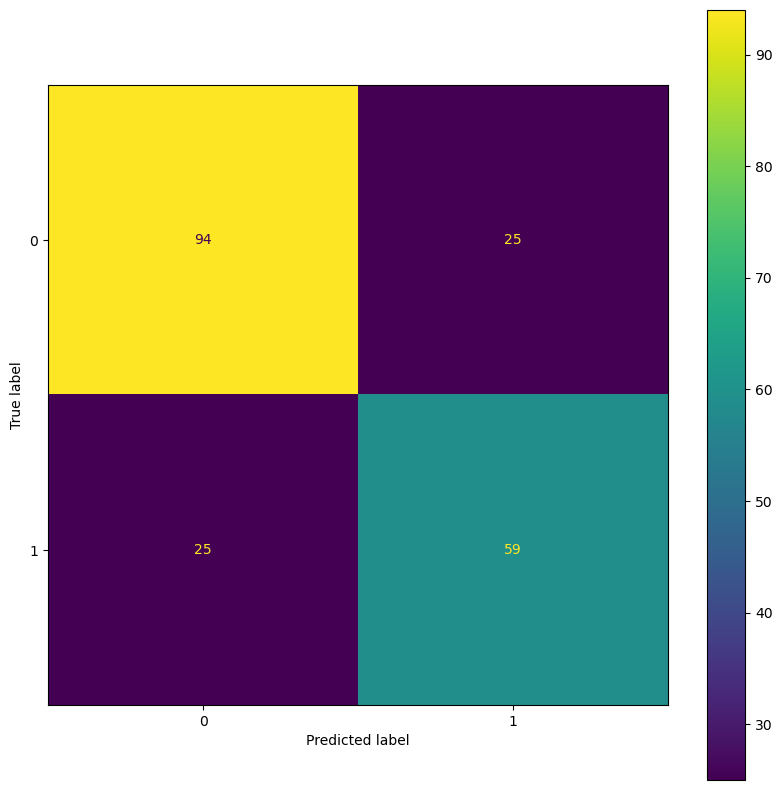

In [48]:
fig, ax = plt.subplots(figsize=(10,10))
ConfusionMatrixDisplay.from_predictions(y_test_aqs, y_pred, ax=ax);

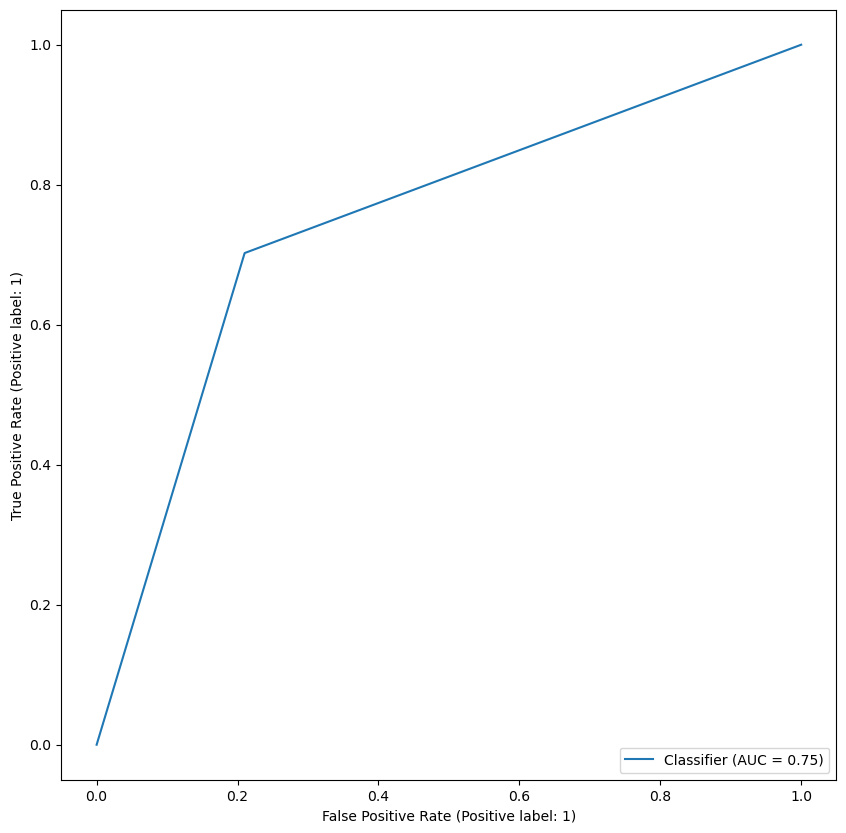

In [49]:
fig, ax = plt.subplots(figsize=(10,10))
RocCurveDisplay.from_predictions(y_test_aqs, y_pred, ax=ax);